Data 100 Final Project - COVID19 Dataset

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap 
import seaborn as sns

In [9]:
april_18 = pd.read_csv("4.18states.csv")
april_18.head(10)

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780
5,California,US,2020-04-18 22:32:47,36.1162,-119.6816,30491,1140,NaN,29351.0,6.0,77.766063,251614.0,4892.0,3.738808,84000006,USA,641.731334,16.044079
6,Colorado,US,2020-04-18 22:32:47,39.0598,-105.3111,9047,389,NaN,8658.0,8.0,159.648818,43307.0,1755.0,4.299768,84000008,USA,764.221442,19.398696
7,Connecticut,US,2020-04-18 22:32:47,41.5978,-72.7554,17550,1086,NaN,16464.0,9.0,492.246487,55462.0,1946.0,6.188034,84000009,USA,1555.611091,11.088319
8,Delaware,US,2020-04-18 22:32:47,39.3185,-75.5071,2538,67,423.0,2471.0,10.0,260.638101,14017.0,224.0,2.639874,84000010,USA,1439.465825,8.825847
9,Diamond Princess,US,2020-04-18 22:32:47,NaN,NaN,49,0,0.0,49.0,88888.0,NaN,NaN,NaN,0.000000,84088888,USA,NaN,NaN


In [10]:
abridged_counties = pd.read_csv("abridged_couties.csv")
abridged_counties.head(10)

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,7.21,31850.0,25233.0
5,01011,1.0,11.0,Bullock,AL,Alabama,32.106336,-85.716804,32.116327,-85.701192,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.8898,2.38,3000.0,7153.0
6,01013,1.0,13.0,Butler,AL,Alabama,31.757139,-86.684347,31.773539,-86.653550,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.8653,1.31,16290.0,3918.0
7,01015,1.0,15.0,Calhoun,AL,Alabama,33.776245,-85.829561,33.725460,-85.819442,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.8252,4.24,35160.0,12712.0
8,01017,1.0,17.0,Chambers,AL,Alabama,32.916331,-85.394853,32.860439,-85.266474,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.7382,NaN,NaN,NaN
9,01019,1.0,19.0,Cherokee,AL,Alabama,34.191471,-85.604220,34.179333,-85.629194,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4516,2.75,15855.0,9610.0


In [11]:
confirmed = pd.read_csv("time_series_covid19_confirmed_US.csv")
confirmed.head(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,...,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,...,45,50,51,51,51,51,51,51,51,53
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,15,17,19,19,19,23,24,26,26,25
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,56,59,66,71,72,87,91,101,103,109
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,4,9,9,10,10,11,12,14,15,18
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,9,11,13,16,17,17,18,22,24,26
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,11,12,12,13,14,16,17,18,20,20


In [12]:
deaths = pd.read_csv("time_series_covid19_deaths_US.csv")
deaths.head(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,4,4,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,...,33,39,42,44,45,45,51,56,58,60
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,...,1,1,1,1,1,1,1,1,2,3
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,1,1,1,1,1,1,1,1,2,2
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,1,1,1,1,1,2,2,2,2,2
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,0,0,0,0,0,0,0,0,0,0
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,0,0,0,0,0,0,0,0,0,0
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,0,0,0,0,0,0,0,0,0,0


In [23]:
print(deaths.isna().sum().sum())
print(confirmed.isna().sum().sum())
print(abridged_counties.isna().sum().sum())
print(april_18.isna().sum().sum())
#Should do something about the NaN values in abridged_counties

11
11
30143
558


In [20]:
confirmed.isna().sum().sum()

11

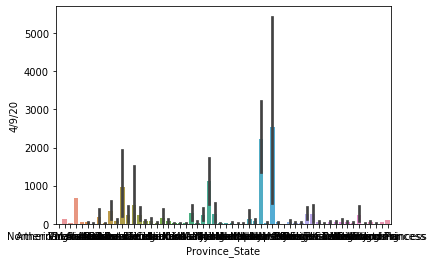

In [17]:
sns.barplot(data=confirmed, x="Province_State", y="4/9/20")